In [95]:
import os
from urllib.request import urlopen
import ssl, certifi
import pandas as pd
import plotly.express as px

os.makedirs("../data", exist_ok=True)

ctx = ssl.create_default_context(cafile=certifi.where())

urls = {
    "unvotes":    "https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2021/2021-03-23/unvotes.csv",
    "roll_calls": "https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2021/2021-03-23/roll_calls.csv",
    "issues":     "https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2021/2021-03-23/issues.csv",
}

for name, url in urls.items():
    with urlopen(url, context=ctx) as f:
        df = pd.read_csv(f)
    out_path = f"../data/{name}.csv"
    df.to_csv(out_path, index=False)
    print(f"✅ Saved to {out_path}")

✅ Saved to ../data/unvotes.csv
✅ Saved to ../data/roll_calls.csv
✅ Saved to ../data/issues.csv


In [96]:
unvotes    = pd.read_csv('../data/unvotes.csv')
roll_calls = pd.read_csv('../data/roll_calls.csv')
issues = pd.read_csv('../data/issues.csv')

print(unvotes.head())
print(roll_calls.head())
print(issues.head())

   rcid             country country_code vote
0     3       United States           US  yes
1     3              Canada           CA   no
2     3                Cuba           CU  yes
3     3               Haiti           HT  yes
4     3  Dominican Republic           DO  yes
   rcid  session  importantvote        date    unres  amend  para  \
0     3        1            0.0  1946-01-01   R/1/66    1.0   0.0   
1     4        1            0.0  1946-01-02   R/1/79    0.0   0.0   
2     5        1            0.0  1946-01-04   R/1/98    0.0   0.0   
3     6        1            0.0  1946-01-04  R/1/107    0.0   0.0   
4     7        1            0.0  1946-01-02  R/1/295    1.0   0.0   

                            short  \
0  AMENDMENTS, RULES OF PROCEDURE   
1      SECURITY COUNCIL ELECTIONS   
2                VOTING PROCEDURE   
3     DECLARATION OF HUMAN RIGHTS   
4      GENERAL ASSEMBLY ELECTIONS   

                                               descr  
0  TO ADOPT A CUBAN AMENDMENT T

## Ultimate outer merge

In [97]:
import pandas as pd

# 1. Load the three CSV files into pandas DataFrames
unvotes    = pd.read_csv('../data/unvotes.csv')
roll_calls = pd.read_csv('../data/roll_calls.csv')
issues = pd.read_csv('../data/issues.csv')
# 2. Perform the outer merge on the three DataFrames using 'rcid' as the key
merged_df = roll_calls.merge(unvotes, on="rcid", how="outer").merge(issues, on="rcid", how="outer")

# 3. Reset index if you want to drop the old index column and get a clean index
merged_df = merged_df.reset_index(drop=True)

# 4. Save the merged DataFrame to a local folder as a CSV file
merged_df.to_csv("merged_data.csv", index=False)

# Optional: You can save it as an Excel or JSON if needed:
# merged_df.to_excel("path/to/save/merged_data.xlsx", index=False)
# merged_df.to_json("path/to/save/merged_data.json", orient="records", lines=True)

print("Merge completed and saved to local folder.")


Merge completed and saved to local folder.


In [98]:
merged_df.columns.unique()

#prove outer merge is completed
merged_df.shape
merged_df.head()


,rcid,session,importantvote,date,unres,amend,para,short,descr,country,country_code,vote,short_name,issue
0,3,1,0.0,1946-01-01,R/1/66,1.0,0.0,"AMENDMENTS, RULES OF PROCEDURE",TO ADOPT A CUBAN AMENDMENT TO THE UK PROPOSAL ...,United States,US,yes,NaN,NaN
1,3,1,0.0,1946-01-01,R/1/66,1.0,0.0,"AMENDMENTS, RULES OF PROCEDURE",TO ADOPT A CUBAN AMENDMENT TO THE UK PROPOSAL ...,Canada,CA,no,NaN,NaN
2,3,1,0.0,1946-01-01,R/1/66,1.0,0.0,"AMENDMENTS, RULES OF PROCEDURE",TO ADOPT A CUBAN AMENDMENT TO THE UK PROPOSAL ...,Cuba,CU,yes,NaN,NaN
3,3,1,0.0,1946-01-01,R/1/66,1.0,0.0,"AMENDMENTS, RULES OF PROCEDURE",TO ADOPT A CUBAN AMENDMENT TO THE UK PROPOSAL ...,Haiti,HT,yes,NaN,NaN
4,3,1,0.0,1946-01-01,R/1/66,1.0,0.0,"AMENDMENTS, RULES OF PROCEDURE",TO ADOPT A CUBAN AMENDMENT TO THE UK PROPOSAL ...,Dominican Republic,DO,yes,NaN,NaN


## Question: "How do different regions vote on the key issue (Human Rights) in the UN, and have there been any noticeable shifts in voting behavior over time?"

### Show not all countries have country_code

In [99]:
# Filter rows where country_code is missing (NaN)
missing_country_code = merged_df[merged_df["country_code"].isna()]

# Get unique countries where country_code is missing
unique_countries_with_missing_code = missing_country_code['country'].unique()

# Display the result
print(unique_countries_with_missing_code)

['Yemen Arab Republic' 'Zanzibar' 'Federal Republic of Germany' 'Namibia']


Notes: 
Remove session cause each session refers to one year, 1 = 1946
Remove para. Because it is only on a paragraph and not a resolution. And it stops at 1985, which falls out of the date region we are trying to visualise
Same for amend
Remove unres. Because its a unique key as RCID and less sophisticated
Remove describe. Because every single line is unique and its very hard to filter out the info

Convert date to datetime. Then, extract the year from it\
The reason why we remove session and kept year is cause we can visualise it better
Countr_code. Not all countries have country_code hence there will be NA values. So we drop it 

Dont need short name as it is exactly the same as issue 


In [100]:
print(merged_df['short_name'].unique())
print(merged_df['issue'].unique())

[nan 'hr' 'ec' 'co' 'me' 'di' 'nu']
[nan 'Human rights' 'Economic development' 'Colonialism'
 'Palestinian conflict' 'Arms control and disarmament'
 'Nuclear weapons and nuclear material']


In [101]:
merged_df.columns.unique()

Index(['rcid', 'session', 'importantvote', 'date', 'unres', 'amend', 'para',
       'short', 'descr', 'country', 'country_code', 'vote', 'short_name',
       'issue'],
      dtype='object')

In [102]:
#Pick only the columns we need
final_df = merged_df[['rcid', 'date', 'country', 'vote', 'issue', 'importantvote', 'short']].copy()
print(final_df.tail())

         rcid        date    country     vote issue  importantvote  \
1123329  9147  2019-12-10    Uruguay      yes   NaN            NaN   
1123330  9147  2019-12-10    Vanuatu      yes   NaN            NaN   
1123331  9147  2019-12-10  Venezuela  abstain   NaN            NaN   
1123332  9147  2019-12-10    Vietnam      yes   NaN            NaN   
1123333  9147  2019-12-10     Zambia      yes   NaN            NaN   

                                  short  
1123329  Oceans and the law of the sea   
1123330  Oceans and the law of the sea   
1123331  Oceans and the law of the sea   
1123332  Oceans and the law of the sea   
1123333  Oceans and the law of the sea   


In [103]:
print(final_df['issue'].nunique())
print(final_df['issue'].unique())
print(final_df['short'].nunique())

#therefore both of them are different and we cant merge inner 


6
[nan 'Human rights' 'Economic development' 'Colonialism'
 'Palestinian conflict' 'Arms control and disarmament'
 'Nuclear weapons and nuclear material']
2020


In [104]:
# 3. Reset index if you want to drop the old index column and get a clean index
final_df = final_df.reset_index(drop=True)

# 4. Save the merged DataFrame to a local folder as a CSV file
final_df.to_csv("final_merged_data.csv", index=False)

### Extract only year for date (using datetime)

In [105]:
final_df['date'] = pd.to_datetime(final_df['date']).dt.year
# sort values by date
final_df = final_df.sort_values(by='date')
print(final_df.tail())

         rcid  date               country     vote issue  importantvote  \
1107298  9087  2019  Bosnia & Herzegovina       no   NaN            NaN   
1107297  9087  2019               Bolivia  abstain   NaN            NaN   
1107296  9087  2019                Bhutan      yes   NaN            NaN   
1107305  9087  2019              Cambodia      yes   NaN            NaN   
1123333  9147  2019                Zambia      yes   NaN            NaN   

                                                     short  
1107298  Countering the use of information and communic...  
1107297  Countering the use of information and communic...  
1107296  Countering the use of information and communic...  
1107305  Countering the use of information and communic...  
1123333                     Oceans and the law of the sea   


### Create the graph trend below but across time from 1946-2019

In [123]:
afgan = final_df[(final_df['date'] >= 1999) & (final_df['date'] <= 2021)].copy()
afgan = afgan[afgan['vote'] == 'yes']
#print(ww2)

#change from issue to issue counts/ from long df to wide df
#now we no longer need vote column since all yes votes 
afgan = afgan.drop(columns=['vote'])
#dont need short since too many categories 
afgan = afgan.drop(columns=['short'])
#drop the na values in issue column since we dk what issue it falls under? so we cant assign a value
afgan = afgan.dropna(subset=['issue'])
#drop importantvote since we are counting number of issues voted yes on and USA is the one deeming who is importantvote
afgan = afgan.drop(columns=['importantvote'])
#group by date and country and count number of issues voted yes on
afgan['yescounts'] = afgan.groupby(['date', 'country'])['issue'].transform('count')
print(afgan['issue'].unique())

['Nuclear weapons and nuclear material' 'Arms control and disarmament'
 'Human rights' 'Economic development' 'Palestinian conflict'
 'Colonialism']


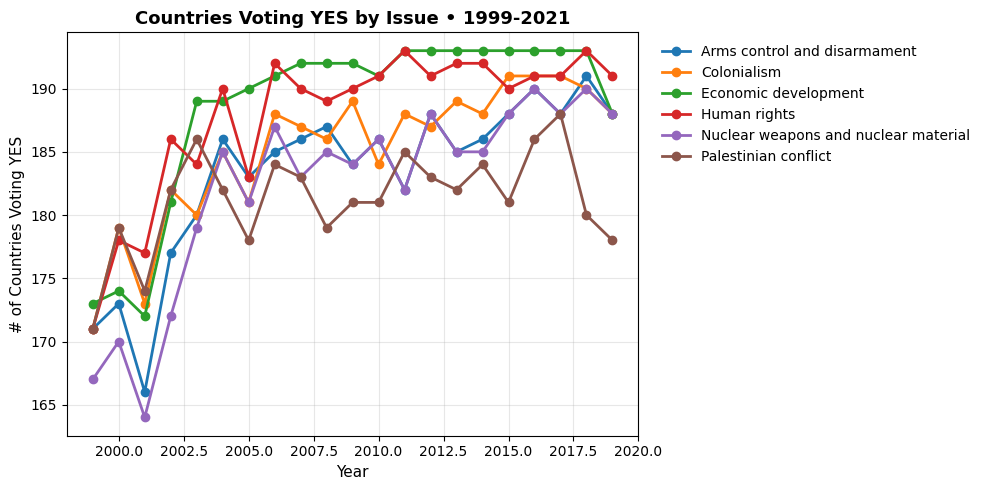

In [125]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Data prep ---
df = afgan.dropna(subset=['issue']).copy()
df['date'] = df['date'].astype(int)

# Count how many countries voted YES per (year, issue)
issue_year = (
    df.groupby(['date','issue'])['country'].nunique()
      .reset_index(name='countries_yes')
)

# --- Plot ---
plt.figure(figsize=(10,5))

# Plot each issue trend line
for issue in sorted(issue_year['issue'].unique()):
    d = issue_year[issue_year['issue'] == issue].sort_values('date')
    plt.plot(d['date'], d['countries_yes'], marker='o', linewidth=2, label=issue)

# Title, labels, and styling
plt.title('Countries Voting YES by Issue • 1999-2021', fontsize=13, fontweight='bold')
plt.xlabel('Year', fontsize=11)
plt.ylabel('# of Countries Voting YES', fontsize=11)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)
plt.tight_layout()
plt.show()


### Analyse how importance of issues change overtime a decade after ww2

In [108]:
ww2 = final_df[(final_df['date'] >= 1945) & (final_df['date'] <= 1955)].copy()
ww2 = ww2[ww2['vote'] == 'yes']
#print(ww2)

#change from issue to issue counts/ from long df to wide df
#now we no longer need vote column since all yes votes 
ww2 = ww2.drop(columns=['vote'])
#dont need short since too many categories 
ww2 = ww2.drop(columns=['short'])
#drop the na values in issue column since we dk what issue it falls under? so we cant assign a value
ww2 = ww2.dropna(subset=['issue'])
#drop importantvote since we are counting number of issues voted yes on and USA is the one deeming who is importantvote
ww2 = ww2.drop(columns=['importantvote'])
#group by date and country and count number of issues voted yes on
ww2['yescounts'] = ww2.groupby(['date', 'country'])['issue'].transform('count')
print(ww2['issue'].unique)

<bound method Series.unique of 1535      Colonialism
1531      Colonialism
1530      Colonialism
1529      Colonialism
1528      Colonialism
             ...     
25884    Human rights
25885    Human rights
25886    Human rights
25888    Human rights
25887    Human rights
Name: issue, Length: 6499, dtype: object>


In [109]:
#print out issue column with unique values
print(ww2['issue'].unique())
#print out rows that have issue as 'Nuclear Weapons and Nuclear Material'
print(ww2[ww2['issue'] == 'Nuclear weapons and nuclear material'].tail())

['Colonialism' 'Economic development' 'Human rights'
 'Palestinian conflict' 'Arms control and disarmament'
 'Nuclear weapons and nuclear material']
       rcid  date         country                                 issue  \
11256   200  1949         Ukraine  Nuclear weapons and nuclear material   
11254   200  1949          Russia  Nuclear weapons and nuclear material   
11250   200  1949      Yugoslavia  Nuclear weapons and nuclear material   
11248   200  1949  Czechoslovakia  Nuclear weapons and nuclear material   
11246   200  1949          Poland  Nuclear weapons and nuclear material   

       yescounts  
11256         36  
11254         36  
11250         20  
11248         37  
11246         36  


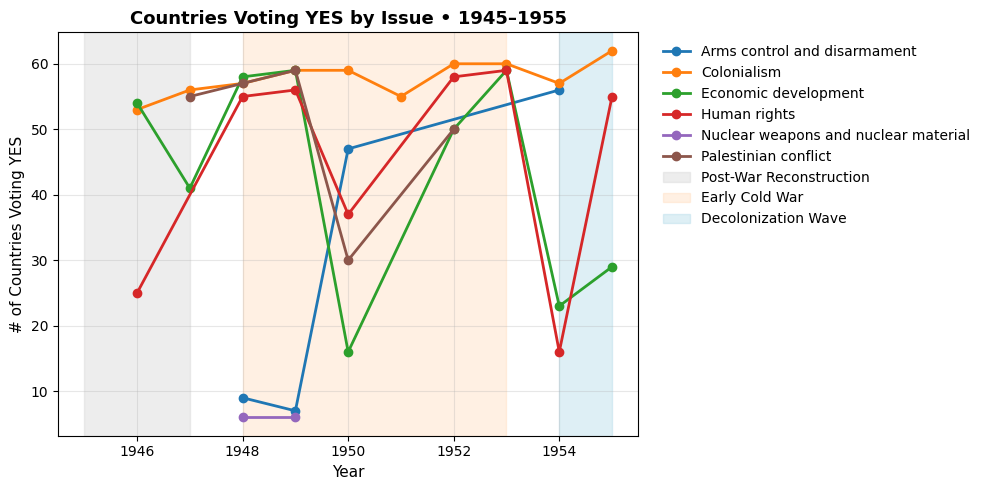

In [110]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Data prep ---
df = ww2.dropna(subset=['issue']).copy()
df['date'] = df['date'].astype(int)

# Count how many countries voted YES per (year, issue)
issue_year = (
    df.groupby(['date','issue'])['country'].nunique()
      .reset_index(name='countries_yes')
)

# --- Plot ---
plt.figure(figsize=(10,5))

# Plot each issue trend line
for issue in sorted(issue_year['issue'].unique()):
    d = issue_year[issue_year['issue'] == issue].sort_values('date')
    plt.plot(d['date'], d['countries_yes'], marker='o', linewidth=2, label=issue)

# Add contextual historical shading
plt.axvspan(1945, 1947, color='lightgrey', alpha=0.4, label='Post-War Reconstruction')
plt.axvspan(1948, 1953, color='peachpuff', alpha=0.4, label='Early Cold War')
plt.axvspan(1954, 1955, color='lightblue', alpha=0.4, label='Decolonization Wave')

# Title, labels, and styling
plt.title('Countries Voting YES by Issue • 1945–1955', fontsize=13, fontweight='bold')
plt.xlabel('Year', fontsize=11)
plt.ylabel('# of Countries Voting YES', fontsize=11)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)
plt.tight_layout()
plt.show()


### Which issues are deemed more important (based on importantvote)?

In [111]:
usa_df = final_df.copy() 
usa_df = usa_df[['country', 'issue', 'importantvote', 'vote']]
usa_df = usa_df.dropna(subset=['issue', 'importantvote']).reset_index(drop=True)
print(usa_df.head())

          country        issue  importantvote     vote
0         Ukraine  Colonialism            0.0       no
1          Russia  Colonialism            0.0       no
2          Greece  Colonialism            0.0      yes
3      Yugoslavia  Colonialism            0.0       no
4  Czechoslovakia  Colonialism            0.0  abstain


### Check the different types of important vote

In [112]:
print(usa_df['importantvote'].unique())
print(usa_df['issue'].unique())
print(usa_df['vote'].unique())

[0. 1.]
['Colonialism' 'Economic development' 'Human rights'
 'Palestinian conflict' 'Arms control and disarmament'
 'Nuclear weapons and nuclear material']
['no' 'yes' 'abstain']


### Sum up importantvotes 

In [113]:
usa_df['importance'] = usa_df.groupby('issue')['importantvote'].transform('sum')
print(usa_df.head())
usa_df


          country        issue  importantvote     vote  importance
0         Ukraine  Colonialism            0.0       no      5443.0
1          Russia  Colonialism            0.0       no      5443.0
2          Greece  Colonialism            0.0      yes      5443.0
3      Yugoslavia  Colonialism            0.0       no      5443.0
4  Czechoslovakia  Colonialism            0.0  abstain      5443.0


,country,issue,importantvote,vote,importance
0,Ukraine,Colonialism,0.0,no,5443.0
1,Russia,Colonialism,0.0,no,5443.0
2,Greece,Colonialism,0.0,yes,5443.0
3,Yugoslavia,Colonialism,0.0,no,5443.0
4,Czechoslovakia,Colonialism,0.0,abstain,5443.0
...,...,...,...,...,...
783209,Burkina Faso,Economic development,0.0,yes,11309.0
783210,Bulgaria,Economic development,0.0,yes,11309.0
783211,Brunei,Economic development,0.0,yes,11309.0
783212,Burundi,Economic development,0.0,yes,11309.0


### Plotting of graph

In [114]:
# Group by 'issue' and calculate the average importance for each issue
issue_importance = usa_df.groupby('issue')['importance'].mean().reset_index()

# Create a bar plot
fig = px.bar(
    issue_importance,
    x='issue',  # Issues on the x-axis
    y='importance',  # Average importance on the y-axis
    title="Average Importance of Issues in UN Votes",
    labels={"importance": "Average Importance", "issue": "Issue"},
    color='importance',  # Color by importance for better visualization
    color_continuous_scale="Viridis"  # Choose color scale
)

fig.update_layout(
    xaxis_title="Issue",
    yaxis_title="Average Importance"
)

# Show the plot
fig.show()


## Bryan's Graph

### Clean up the data to only take issues that are Human rights

In [115]:
import plotly.graph_objects as go

# Filter data for 'Human rights' issue
human_rights_data = final_df[final_df['issue'] == 'Human rights']
print(human_rights_data.head())


      rcid  date         country     vote         issue  importantvote  \
2077    41  1946     New Zealand       no  Human rights            0.0   
2027    41  1946          Poland      yes  Human rights            0.0   
2029    41  1946  Czechoslovakia      yes  Human rights            0.0   
2031    41  1946      Yugoslavia      yes  Human rights            0.0   
2033    41  1946          Greece  abstain  Human rights            0.0   

                   short  
2077  ECOSOC CONSULTANTS  
2027  ECOSOC CONSULTANTS  
2029  ECOSOC CONSULTANTS  
2031  ECOSOC CONSULTANTS  
2033  ECOSOC CONSULTANTS  


### Prints graph of votes against year 

In [116]:
import plotly.express as px

# Filter data for 'Human rights' issue
human_rights_data = final_df[final_df['issue'] == 'Human rights']
print(human_rights_data.head())

# Group the data by 'date' and 'vote' to count the occurrences
human_rights_data = (human_rights_data
                     .groupby(['date', 'vote'])
                     .size()
                     .reset_index(name='count')
)
print(human_rights_data)

# Use plotly express to create a line plot
fig = px.line(human_rights_data, 
              x='date', 
              y='count', 
              color='vote', 
              labels={'date': 'Year', 'count': 'Number of Votes'},
              title='Voting Behavior on Human Rights Issue Over Time')

# Show the plot
fig.show()

      rcid  date         country     vote         issue  importantvote  \
2077    41  1946     New Zealand       no  Human rights            0.0   
2027    41  1946          Poland      yes  Human rights            0.0   
2029    41  1946  Czechoslovakia      yes  Human rights            0.0   
2031    41  1946      Yugoslavia      yes  Human rights            0.0   
2033    41  1946          Greece  abstain  Human rights            0.0   

                   short  
2077  ECOSOC CONSULTANTS  
2027  ECOSOC CONSULTANTS  
2029  ECOSOC CONSULTANTS  
2031  ECOSOC CONSULTANTS  
2033  ECOSOC CONSULTANTS  
     date     vote  count
0    1946  abstain     20
1    1946       no     55
2    1946      yes     27
3    1948  abstain     73
4    1948       no    173
..    ...      ...    ...
199  2018       no    397
200  2018      yes   2842
201  2019  abstain    495
202  2019       no    329
203  2019      yes   1734

[204 rows x 3 columns]


### LeiFeis graph

### Check occurrence of the votes per country across the years

In [117]:
# Filter the DataFrame for "Human rights" issue and capitalize the vote values
human_rights = final_df[final_df["issue"] == "Human rights"].copy()
human_rights["vote"] = human_rights["vote"].str.capitalize()

# Group by country and vote to count occurrences
vote_counts = human_rights.groupby(["country", "vote"]).size().reset_index(name="count")

# Pivot the DataFrame to get votes per country per vote type
country_votes = vote_counts.pivot(index="country", columns="vote", values="count").fillna(0)
country_votes = country_votes.reset_index()
country_votes

vote,country,Abstain,No,Yes
0,Afghanistan,59,67,798
1,Albania,162,123,500
2,Algeria,88,57,815
3,Andorra,152,111,279
4,Angola,106,21,631
...,...,...,...,...
194,Yemen Arab Republic,50,13,316
195,Yemen People's Republic,13,19,322
196,Yugoslavia,138,127,602
197,Zambia,118,13,803


### Now group country by region using an external library 

In [118]:
# pip install country_converter
# python -m pip install country_converter

import country_converter as coco

cc = coco.CountryConverter()
country_votes['region'] = cc.convert(names=country_votes['country'].tolist(), to='continent')

# check unmapped
print(country_votes[country_votes['region'].isin(['not found', None])]['country'].unique())

# aggregate by region
region_summary = country_votes.groupby('region').sum(numeric_only=True).reset_index()
print(region_summary)

German Democratic Republic not found in regex
Yugoslavia not found in regex


['German Democratic Republic' 'Yugoslavia']
vote     region  Abstain    No    Yes
0        Africa     6085  1321  35756
1       America     4263  2284  24298
2          Asia     5241  3218  30558
3        Europe     9440  6286  18648
4       Oceania     1975  1314   4765
5     not found      149   141    881


### Renames the region from not found to others and see what the available regions are

In [119]:
#Print out region names 
print(region_summary['region'].unique())

#rename not found to others 
region_summary['region'] = region_summary['region'].replace('not found', 'Others')
print(region_summary['region'].unique())

['Africa' 'America' 'Asia' 'Europe' 'Oceania' 'not found']
['Africa' 'America' 'Asia' 'Europe' 'Oceania' 'Others']


### Plot a map 
### Plot heatmap (Choice 1)

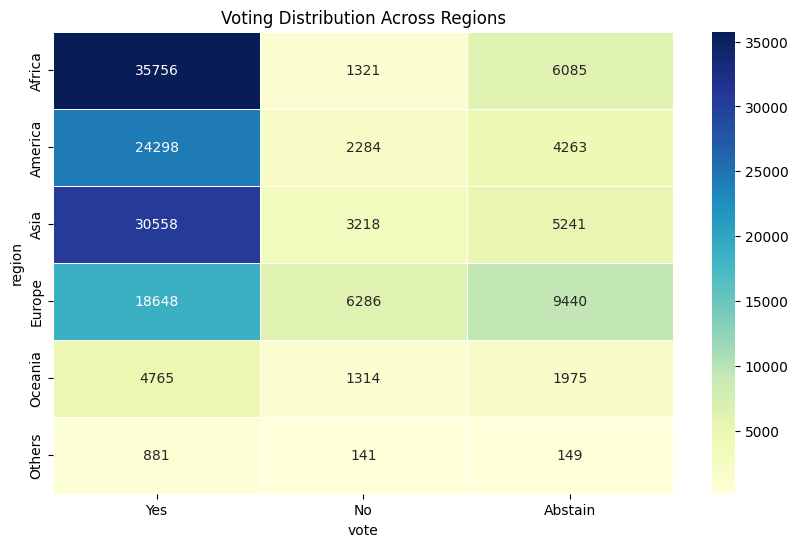

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up data in a format suitable for a heatmap
heatmap_data = region_summary.set_index('region')[['Yes', 'No', 'Abstain']]

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', cbar=True, fmt="d", linewidths=.5)
plt.title("Voting Distribution Across Regions")
plt.show()


### Plot world map (Choice 2)

In [121]:
import pandas as pd
import plotly.express as px
import pycountry

human_rights = final_df[final_df["issue"] == "Human rights"].copy()
human_rights["vote"] = human_rights["vote"].str.capitalize()

# Group by country, date, and vote type, then count occurrences of each vote type
agg = human_rights.groupby(['country', 'date', 'vote']).size().reset_index(name='count')

# Calculate the total number of votes for each country and date
total_votes = agg.groupby(['country', 'date'])['count'].transform('sum')

# Calculate the percentage of each vote type for each country and date
agg['pct_votes'] = agg['count'] / total_votes  # Percentage of votes for each type

# Map country names to ISO3 using pycountry
def name_to_iso3(n):
    try:
        return pycountry.countries.lookup(n).alpha_3
    except Exception:
        return None

# Add a new column for ISO3 country code
agg['iso3'] = agg['country'].map(name_to_iso3)

# Filter out rows where country could not be mapped to an ISO3 code
agg = agg[agg['iso3'].notna()]

# Verify the DataFrame
print(agg.head())

# Create an animated choropleth map
fig = px.choropleth(
    agg,
    locations='iso3',  # Use ISO3 country codes for plotting
    color='pct_votes',  # Use the percentage of votes to color countries
    animation_frame='vote',  # Animate based on vote type (Yes, No, Abstain)
    color_continuous_scale='RdYlBu_r',  # Choose a color scale
    range_color=[0, 1],  # Define the range of color (0 to 1)
    title='% Votes by Country on Human Rights',
    labels={'pct_votes': 'Percentage of Votes'}
)

# Show the plot
fig.show()


       country  date     vote  count  pct_votes iso3
0  Afghanistan  1946       No      1   1.000000  AFG
1  Afghanistan  1948  Abstain      5   0.833333  AFG
2  Afghanistan  1948      Yes      1   0.166667  AFG
3  Afghanistan  1949  Abstain      6   1.000000  AFG
4  Afghanistan  1950      Yes      2   1.000000  AFG
